In [381]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import re
%matplotlib inline

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

## We're going to read and analyze Yelp reviews:

In [382]:
yelp_df = pd.read_csv('yelp_labelled.txt',delimiter='\t',header=None,names=['sentiment','positive'])

In [383]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
sentiment    1000 non-null object
positive     1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


In [384]:
# Transform the positive column to True/False
yelp_df['positive'] = (yelp_df['positive'] == 1)
# Note that if you run this cell a second time everything will become false.
# So... Don't.

### Choose some words to help train the model to recognize positive reviews.

In [385]:
def build_keyword_variables(df,kw_dict):
    for keyword, keypattern in kw_dict.items():
# In the guided example, this had spaces hard-coded around the keyword.
# I want more flexibility--I will use regular expressions instead of just words here
        df[str(keyword)] = df['sentiment'].str.contains(keypattern,case=False)
    
# Flip the results for keywords whose descriptions start with "no "
    for no_keyword in [x for x in kw_dict if re.search('no ',x)]:
        print("Flipping results for variable: {}".format(no_keyword))
        df[str(no_keyword)] = (df[str(no_keyword)] == False)
    return df

In [386]:
# I'm using a dict so I can define patterns but still have clean variable names in the dataframe
kw_dict = {'love': ' love[ dl]*',
           'great': ' great',
           'best': 'best ',
           'fast': ' fast',
           'friendly': 'friendly',
           'amazing': 'amazing',
           'awesome': 'awesome',
           'excellent': 'excellent',
           'good': ' good ',
           'glad': 'glad',
           'prompt': 'prompt',
           'delicious': 'delicious',
           'nice': 'nice',
           'refreshing': 'refreshing',
           'enjoy': ' enjoy[ed]*',
           'moist': 'moist',
           'yummy': 'yummy',
           'a lot': 'a lot',
           'recommend': 'recommend',
# We will flip the results of columns whose descriptions start with "no ",
# so they help us understand when words are NOT present.
           'no good': 'not.*?good',
           'no at best': 'at best',
           'no but': ' but ',
           'no no': ' no ',
           'no not': 'not ',
           'no problem': ' problem',
          }

In [387]:
test_df = build_keyword_variables(yelp_df,kw_dict)
test_df.head()

Flipping results for variable: no good
Flipping results for variable: no at best
Flipping results for variable: no but
Flipping results for variable: no no
Flipping results for variable: no not
Flipping results for variable: no problem


,sentiment,positive,love,great,best,fast,friendly,amazing,awesome,excellent,good,glad,prompt,delicious,nice,refreshing,enjoy,moist,yummy,a lot,recommend,no good,no at best,no but,no no,no not,no problem
0,Wow... Loved this place.,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
1,Crust is not good.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True
2,Not tasty and the texture was just nasty.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,True
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True
4,The selection on the menu was great and so were the prices.,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True


In [388]:
test_df.describe(exclude=['object'])

,positive,love,great,best,fast,friendly,amazing,awesome,excellent,good,glad,prompt,delicious,nice,refreshing,enjoy,moist,yummy,a lot,recommend,no good,no at best,no but,no no,no not,no problem
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
freq,500,968,950,978,995,973,976,988,990,944,998,998,976,973,999,989,997,996,993,982,986,995,944,981,887,999


### Verify that the keywords are largely independent.

The heatmap should show very little correlation between the variables we created based on our keywords.

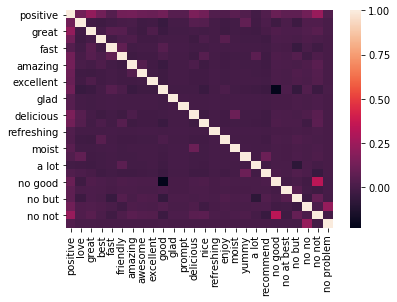

In [389]:
sns.heatmap(yelp_df.corr())

### Create training and target data for the model, and run it.

In [390]:
data = yelp_df[kw_dict.keys()]
target = yelp_df['positive']

In [391]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

In [392]:
# Add the classification from the model to a new column so we can browse the output
yelp_df['nb_positive'] = y_pred

### What's a mismatch between the reviews that were classified as positive, and what the model thinks is positive?

In [393]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 279


In [394]:
yelp_df.loc[(yelp_df['positive'] != yelp_df['nb_positive']),['positive','nb_positive','sentiment']]

,positive,nb_positive,sentiment
13,True,False,"I tried the Cape Cod ravoli, chicken,with cranberry...mmmm!"
22,True,False,Service is also cute.
23,True,False,I could care less... The interior is just beautiful.
24,True,False,So they performed.
25,True,False,That's right....the red velvet cake.....ohhh this stuff is so good.
30,True,False,"Also there are combos like a burger, fries, and beer for 23 which is a decent deal."
32,True,False,I found this place by accident and I could not be happier.
33,False,True,"seems like a good quick place to grab a bite of some familiar pub food, but do yourself a favor and look elsewhere."
34,True,False,"Overall, I like this place a lot."
35,True,False,The only redeeming quality of the restaurant was that it was very inexpensive.


## Now, let's see what happens if we feed Amazon data to this model.

In [395]:
amazon_df = pd.read_csv('amazon_cells_labelled.txt',delimiter='\t',header=None,names=['sentiment','positive'])

In [396]:
amazon_df.head()

,sentiment,positive
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


In [397]:
# Transform the positive column to True/False
amazon_df['positive'] = (amazon_df['positive'] == 1)
# Note that if you run this cell a second time everything will become false.
# So... Don't.

In [398]:
test2_df = build_keyword_variables(amazon_df,kw_dict)
test2_df.head()

Flipping results for variable: no good
Flipping results for variable: no at best
Flipping results for variable: no but
Flipping results for variable: no no
Flipping results for variable: no not
Flipping results for variable: no problem


,sentiment,positive,love,great,best,fast,friendly,amazing,awesome,excellent,good,glad,prompt,delicious,nice,refreshing,enjoy,moist,yummy,a lot,recommend,no good,no at best,no but,no no,no not,no problem
0,So there is no way for me to plug it in here in the US unless I go by a converter.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True,True
1,"Good case, Excellent value.",True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
2,Great for the jawbone.,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,False
4,The mic is great.,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True


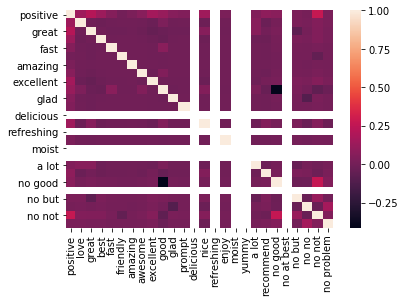

In [399]:
sns.heatmap(amazon_df.corr())

I can see that the food-specific keywords I added to our list (delicious, refreshing, moist, yummy) hold no meaning for Amazon product reviews. I suspect this will translate into results that aren't as good. Let's see.

In [400]:
data2 = amazon_df[kw_dict.keys()]
target2 = amazon_df['positive']

In [401]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb2 = BernoulliNB()

# Fit our model to the data.
bnb2.fit(data2, target2)

# Classify, storing the result in a new variable.
y_pred2 = bnb2.predict(data2)

In [402]:
# Add the classification from the model to a new column so we can browse the output
amazon_df['nb_positive'] = y_pred2

### What's a mismatch between the reviews that were classified as positive, and what the model thinks is positive?

In [403]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data2.shape[0],
    (target2 != y_pred2).sum()
))

Number of mislabeled points out of a total 1000 points : 312


In [404]:
amazon_df.loc[(amazon_df['positive'] != amazon_df['nb_positive']),['positive','nb_positive','sentiment']]

,positive,nb_positive,sentiment
2,True,False,Great for the jawbone.
7,True,False,If you are Razr owner...you must have this!
11,True,False,He was very impressed when going from the original battery to the extended battery.
17,True,False,So Far So Good!.
23,True,False,I have yet to run this new battery below two bars and that's three days without charging.
25,True,False,Great Pocket PC / phone combination.
31,True,False,This product is ideal for people like me whose ears are very sensitive.
36,True,False,It has kept up very well.
45,True,False,It has all the features I want
48,True,False,This case seems well made.


Yeah, there are more mislabeled sentiments here than there were above. I would have to review this output and see which additional keywords would help.

## My feature engineering and selection process

Rather than just cut and paste the code from the guided example, I wanted to create some new features. I came up with two:

1. Using a dict instead of a list allowed me to write some really basic regular expressions in place of using hard-coded keywords. Unfortunately, I wasn't able to make these regexes too sophisticated--using parenthesis to group in a regex generated some warning messages, and appeared to affect the results. (I could probably have added multiple iterations of a word to the keyword list--"love", "loved", "lovely" for instance--but I liked the flexibility of regular expressions.)

2. Because I wasn't able to find a reliable, simple way to use regular expressions to define what I did _not_ want to see in our input sentiments, I created "no" keywords--you can define a simple regular expression to find where words appear, and the function will invert the results, effectively giving me what I wanted. The improvement was modest at best--with six "no" keywords, the model mislabeled 279 sentiments, compared to 292 mislabled sentiments without them, only a 4% difference.

Beyond that, my process was largely iterative. I reviewed some records from the dataframe after loading it, to get a few keywords to start with. I then ran the model and reviewed its output, adding and removing keywords to see how the results changed. I could have spent a lot more time in this step, but I don't think training this model to perfectly recognize the test set was the point...